# DSW formation and export in PanAntarctic experiments

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cosima_cookbook as cc
from collections import OrderedDict
from dask.distributed import Client
import matplotlib.path as mpath

import matplotlib.pyplot as plt
import cmocean.cm as cmo
import matplotlib.colors as col
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter
import matplotlib.ticker as mticker

In [2]:
plt.rcParams['figure.dpi'] = 96
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 3
plt.rcParams['hatch.color'] = 'k'
plt.rcParams["savefig.facecolor"] = 'white'

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 48,Total memory: 180.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33487,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 180.00 GiB
Comm: tcp://127.0.0.1:44433,Total threads: 6
Dashboard: /proxy/35497/status,Memory: 22.50 GiB
Nanny: tcp://127.0.0.1:45633,


## Load data

In [4]:
path_output_DSW = '/g/data/e14/cs6673/mom6_comparison/data_DSW/'
start_time = '1991-01-01'
end_time = '2010-12-31'

In [5]:
exptdict = OrderedDict([
    ('panan_01deg', # 1/10th panantarctic zstar run
     {'expt': 'panan-01-test-oldparams',
      'expt_name': 'panan_01deg_jra55_ryf'}),
    ('panan_005deg', # 1/20th panantarctic zstar run
     {'expt': 'panan_005deg_jra55_ryf_2023_05_17',
      'expt_name': 'panan_005deg_jra55_ryf'})
])

In [6]:
DSW_region = {
    'name': ['Weddell', 'Prydz', 'Adelie', 'Ross'],
    'name_long': ['Weddell Sea', 'Prydz Bay', 'Adélie Coast', 'Ross Sea'],
    'lon': [[-60, -35, -48, -62, -60],
            [48, 73, 74, 48, 48],
            [128-360, 152-360, 152-360, 128-360, 128-360],
            [185-360, 160-360, 164-360, 172-360, 185-360]],
    'lat': [[-71, -75, -78, -75, -71],
            [-65, -66.5, -69, -68, -65],
            [-64.5, -66, -69, -67.5, -64.5],
            [-78, -78, -73, -71.5, -78]],
    'ind_iso_min': [3647, 5151, 581, 1141],
    'ind_iso_max': [4307, 134, 960, 1830]}

## Load data

In [7]:
%%time
ekeys = ['panan_01deg', 'panan_005deg']
for ekey in ekeys:
    e = exptdict[ekey]
    session = cc.database.create_session(e['expt_name'] + '.db')
    

    # SWMT in four DSW formation regions
    ds_SWMT_DSW = xr.open_mfdataset(
        path_output_DSW + 'SWMT_in_DSW_region_' + e['expt_name']  + '*.nc')
    ds_SWMT_DSW = ds_SWMT_DSW.sel(time=slice(start_time[:4], end_time[:4]))
    e['swmt_DSW'] = (
        ds_SWMT_DSW.binned_salt_transformation_in_DSW_region +
        ds_SWMT_DSW.binned_heat_transformation_in_DSW_region).compute()
    # SWMT on shelf
    ds_SWMT = xr.open_mfdataset(
        path_output_DSW + 'SWMT_' + e['expt_name'] + '_mean_*.nc',
        chunks={'yh': '200MB', 'xh': '200MB'})
    e['swmt'] = (ds_SWMT.binned_salt_transformation +
                 ds_SWMT.binned_heat_transformation)
    
    # volume transport across different isobaths
    for contour_depth in [650, 1000, 1500, 2000, 2500]:
        ds_transp = xr.open_mfdataset(
            path_output_DSW + 'vol_transp_across_' + str(contour_depth) +
            'm_isobath_' + e['expt_name'] + '*.nc')
        e['transp' + str(contour_depth) + 'm'] = (
            ds_transp.vol_trans_across_contour.assign_coords(
                {'lon': ds_transp.lon[0, :].drop('time'),
                 'lat': ds_transp.lat[0, :].drop('time')}).sel(
                time=slice(start_time, end_time)))

    # # Transport stream function
    # psi = cc.querying.getvar(
    #     e['expt'], 'vmo', session, frequency='1 monthly',
    #     start_time=start_time, end_time=end_time,
    #     chunks={'xh': '200MB', 'yq': '200MB'}).sum('xh')
    # e['psi'] = (psi.cumsum('rho2_l')-psi.sum('rho2_l'))/1e9

CPU times: user 4.67 s, sys: 2.7 s, total: 7.37 s
Wall time: 11.7 s


## Plots

In [8]:
def plot_swmt_in_each_DSW_region_each_year(expt, time_slice=None):
    e = exptdict[expt]
    if time_slice is None:
        swmt = e['swmt_DSW']
    else:
        swmt = e['swmt_DSW'].sel(time=time_slice)
        
    s_m = lines_colored_by_cmap(
        parameter_to_color=swmt.time, cmap=cmo.haline)

    for a in range(4):
        # maximum SWMT of time mean 
        swmt_max = swmt.mean('time')[swmt.mean('time')[:, a].argmax(
            'isopycnal_bins').values, a]
        # isopycnal bin corresponding to SWMT 70% below its maximum value
        swmt_sig_bin = swmt.isopycnal_bins.sel(
            isopycnal_bins=slice(swmt_max.isopycnal_bins, None)).where(
            swmt.mean('time')[:, a] < swmt_max*.7).min('isopycnal_bins')
        
        plt.subplot(2, 2, a+1)
        for n in range(len(swmt.time)):
            plt.plot(
                swmt[n, :, a], swmt.isopycnal_bins,
                color=s_m.to_rgba(swmt.time[n]))
        cb = plt.colorbar(s_m, orientation='horizontal')
        # plt.plot(
        #     swmt.mean('time')[:, a], swmt.isopycnal_bins,
        #     color='r', linewidth=2, label=('mean ' + str(swmt.time.min().values) +
        #           '-' + str(swmt.time.max().values)))
        # plt.axhline(swmt_sig_bin.values, color='grey')
        # plt.legend()
        plt.xlim(-.2, 2)
        plt.ylim(32.9, 31.9)

        plt.xlabel('Surface water mass transformation (Sv)')
        plt.ylabel('Potential density $\sigma_1\,$(kg$\,$m$^{-3}$)')
        plt.title(str(swmt.area[a].values) + ' in ' + expt, fontweight='bold')

In [9]:
def lines_colored_by_cmap(parameter_to_color, cmap):
    # normalize data into the [0.0, 1.0] interval.
    norm = col.Normalize(
        vmin=np.min(parameter_to_color),
        vmax=np.max(parameter_to_color))

    # create a ScalarMappable and initialize a data structure
    s_m = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    return s_m   

In [20]:
start_time = '1994-01-01'
end_time = '1997-12-31'

In [27]:
for a in range(4):
    # use sigma bin at 70% of mean SWMT in panan_005deg
    e = exptdict['panan_005deg']
    swmt = e['swmt_DSW']
    # maximum SWMT of time mean 
    swmt_max = swmt.mean('time')[swmt.mean('time')[:, a].argmax(
        'isopycnal_bins').values, a]
    # isopycnal bin corresponding to SWMT 70% below its maximum value
    swmt_sig_bin = swmt.isopycnal_bins.sel(
        isopycnal_bins=slice(swmt_max.isopycnal_bins, None)).where(
        swmt.mean('time')[:, a] < swmt_max*.7).min('isopycnal_bins')
    print(swmt.area[a].values)
    for i, ekey in enumerate(ekeys):
        e = exptdict[ekey]
        swmt = e['swmt_DSW']

        swmt_70 = swmt[:, :, a].sel(isopycnal_bins=swmt_sig_bin, method='nearest').sel(
            time=slice(start_time, end_time)).mean('time')
        swmt_max = swmt[:, :, a].max('isopycnal_bins').sel(
            time=slice(start_time, end_time)).mean('time')
        print(ekey, ':', np.round(swmt_70.values, 2), 'Sv')

Weddell
panan_01deg : 0.19 Sv
panan_005deg : 0.54 Sv
Prydz
panan_01deg : 0.51 Sv
panan_005deg : 0.74 Sv
Adelie
panan_01deg : 0.39 Sv
panan_005deg : 0.49 Sv
Ross
panan_01deg : 0.89 Sv
panan_005deg : 1.2 Sv


In [10]:
def plot_swmt_timeseries(ekeys, time_slice=None):

    for a in range(4):
        # use sigma bin at 70% of mean SWMT in panan_005deg
        e = exptdict['panan_005deg']
        swmt = e['swmt_DSW']
        # maximum SWMT of time mean 
        swmt_max = swmt.mean('time')[swmt.mean('time')[:, a].argmax(
            'isopycnal_bins').values, a]
        # isopycnal bin corresponding to SWMT 70% below its maximum value
        swmt_sig_bin = swmt.isopycnal_bins.sel(
            isopycnal_bins=slice(swmt_max.isopycnal_bins, None)).where(
            swmt.mean('time')[:, a] < swmt_max*.7).min('isopycnal_bins')
    
        plt.subplot(4, 1, a+1)
        for i, ekey in enumerate(ekeys):
            e = exptdict[ekey]
            swmt = e['swmt_DSW']

            swmt[:, :, a].sel(isopycnal_bins=swmt_sig_bin, method='nearest').plot(
                label=ekey)
            plt.ylim(0, 1.4)
            if a == 0:
                plt.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 1.2))
            plt.autoscale(enable=True, axis='x', tight=True)
            if a < 3:
                plt.gca().set_xticklabels([])
            plt.xlabel('')
            plt.title('')
            plt.text(.77, .87, str(swmt.area[a].values), fontweight='bold',
                     transform=plt.gca().transAxes)
            plt.text(.88, .87, r'$\sigma_1$=' + str(np.round(swmt_sig_bin.values, 2)),
                     transform=plt.gca().transAxes)

In [11]:
def shelf_mask_isobath(var, contour_depth, resolution, output_mask=False):
    '''
    Masks varibales by the region polewards of a given isobath
    '''
    
    ds_contour = xr.open_dataset(
        '/home/142/cs6673/work/mom6_comparison/Antarctic_slope_contours/' +
        'Antarctic_slope_contour_' + str(contour_depth) + 'm_MOM6_' +
        resolution + 'deg.nc')
    
    shelf_mask = ds_contour.contour_masked_above.sel(yh=slice(var.yh[0], var.yh[-1]))
    yh = ds_contour.yh.sel(yh=slice(var.yh[0], var.yh[-1]))
    xh = ds_contour.xh
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask = shelf_mask.where(shelf_mask == 0)+1
    shelf_mask = shelf_mask.where(shelf_mask == 1, 0)
    
    # multiply the variable with the mask
    masked_var = var * shelf_mask
    
    if output_mask == True:
        return masked_var, shelf_mask
    else:
        return masked_var

In [12]:
def plot_swmt_maps(expt, time_slice=None):
    e = exptdict[expt]
    resolution = expt.split('_')[1][:-3]
    if time_slice is None:
        swmt_DSW = e['swmt_DSW']
        swmt = e['swmt']
    else:
        swmt_DSW = e['swmt_DSW'].sel(time=time_slice)
        swmt = e['swmt'].sel(time=time_slice)

    swmt_DSW = swmt_DSW.mean('time').compute()
    swmt = swmt.mean('time').compute()
    swmt_shelf, shelf_mask = shelf_mask_isobath(
        swmt, 1000, resolution, output_mask=True)
    swmt_shelf = swmt_shelf.where(swmt_shelf != 0)

    swmt_sig_bin = []
    for a in range(4):
        # maximum SWMT of time mean 
        swmt_max = swmt_DSW[swmt_DSW[:, a].argmax(
            'isopycnal_bins').values, a]
        # isopycnal bin corresponding to SWMT 70% below its maximum value
        swmt_sig_bin = np.append(swmt_sig_bin, swmt_DSW.isopycnal_bins.sel(
            isopycnal_bins=slice(swmt_max.isopycnal_bins, None)).where(
            swmt_DSW[:, a] < swmt_max*.7).min('isopycnal_bins').values)
    # mean sig_bin for Prydz and Adelie
    sig_bin = [swmt_sig_bin[0], swmt_sig_bin[1:3].mean(), swmt_sig_bin[3]]
    
    depth = cc.querying.getvar(
        exptdict[expt]['expt'], 'deptho', session, n=1)
    land_mask = (depth*0).fillna(1)
    
    # circle in axes coordinates to use as a boundary for the map
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    for n, a in enumerate([0, 1, 3]):
        ax = plt.subplot(1, 3, n+1, projection=ccrs.SouthPolarStereo())
        ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
        ax.set_boundary(circle, transform=ax.transAxes)
        gl = ax.gridlines(draw_labels=False)
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))

        plt.contourf(
            land_mask.xh, np.concatenate(([-90], land_mask.yh[1:].values)),
            land_mask, colors='silver', levels=[0.5, 2],
            transform=ccrs.PlateCarree(), rasterized=True)

        p1 = plt.pcolormesh(
            swmt_shelf.xh, swmt_shelf.yh,
            swmt_shelf.sel(isopycnal_bins=sig_bin[n], method='nearest')*1e5,
            vmin=0, vmax=2.5, cmap=cmo.matter,
            transform=ccrs.PlateCarree(), rasterized=True)

        plt.contour(shelf_mask.xh, shelf_mask.yh, shelf_mask,
                levels=[0, 1], colors = 'lightgray', linewidth=.7,
                transform=ccrs.PlateCarree())

        plt.plot(DSW_region['lon'][a], DSW_region['lat'][a], 'c',
                 transform=ccrs.PlateCarree(), zorder=4)
        if a == 1:
            plt.plot(DSW_region['lon'][2], DSW_region['lat'][2], 'c',
                     transform=ccrs.PlateCarree(), zorder=4)

        ax.text(0, 0.95, r'$\sigma_{1}$=' + str(sig_bin[n].round(2)),
                fontweight='bold', transform=ax.transAxes)

        if a == 0:
            plt.text(-53, -68, 'Weddell\nSea', fontweight='bold', transform=ccrs.PlateCarree())
        elif a == 1:
            plt.text(43, -78, 'Prydz\nBay', fontweight='bold', transform=ccrs.PlateCarree())
            plt.text(154, -73, 'Adélie\nCoast', fontweight='bold', transform=ccrs.PlateCarree())
        elif a == 3:
            plt.text(-165, -69, 'Ross\nSea', fontweight='bold', transform=ccrs.PlateCarree())

    pos = ax.get_position()
    cax = plt.axes([pos.xmax+.007, pos.ymin+.03, 0.015, (pos.ymax-pos.ymin)-.06])
    cb = plt.colorbar(p1, cax=cax, orientation='vertical', extend='max')
    cb.ax.set_ylabel(r'SWMT ($\times 10^{-5}$m/s)')

In [13]:
def longitude_labels(lon):
    lon = np.round(lon.values, 0)
    lon = ((lon + 180) % 360) - 180
    lon_label = []
    for i, l in enumerate(lon):
        if (l == 0) or (l == 180) or (l == -180):
            lon_label.append(f'{np.abs(l):.0f}' + '°')
        elif l < 0:
            lon_label.append(f'{np.abs(l):.0f}' + '°W')
        elif l > 0:
            lon_label.append(f'{l:.0f}' + '°E')
    return lon_label

In [14]:
def plot_offshore_transp_circumpolar_diff_densities(
    expt, sig=np.arange(1037.13, 1037.18, .01),
    contour_depth=1000, time_slice=None):
    
    fig = plt.figure(figsize=(8, 4))
    
    e = exptdict[expt]
    if time_slice is None:
        transp = e['transp' + str(contour_depth) + 'm']
    else:
        transp = e['transp' + str(contour_depth) + 'm'].sel(
            time=time_slice)

    for i, sigma in enumerate(sig):
        transp.sel(
            rho2_l=slice(sigma, None)).sum('rho2_l').cumsum(
            'contour_index').mean('time').plot(label=np.round(sigma, 2))
        plt.xlabel('')
        plt.ylabel('')
        
    ticks_space = np.int(len(transp.contour_index)/10)
    ticks = transp.contour_index[::ticks_space]
    lon = transp.lon[::ticks_space]
    lon_label = longitude_labels(lon)
    plt.gca().set_xticks(ticks, labels=lon_label)
    
    plt.ylabel('Transport (Sv)')
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.ylim(-.9, None )

    plt.legend(loc='upper left', title=r'$\sigma_2$ > ...')
    plt.text(.07, .02, 'Adélie', fontweight='bold', transform=plt.gca().transAxes)
    plt.text(.24, .02, 'Ross', fontweight='bold', transform=plt.gca().transAxes)
    plt.text(.62, .02, 'Weddell', fontweight='bold', transform=plt.gca().transAxes)
    plt.text(.91, .02, 'Prydz', fontweight='bold', transform=plt.gca().transAxes)

    plt.title('Offshore transport in ' + expt + ' across ' +
              str(contour_depth) + 'm isobath',
              loc='left', fontweight='bold')
    plt.show()

In [15]:
def plot_offshore_transp_circumpolar_diff_resolution(
    contour_depth=1000, sig=1037.17, time_slice=None):
    
    fig = plt.figure(figsize=(8, 4))

    col = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    lines = []
    transp_max = []

    for i, ekey in enumerate(ekeys):
        e = exptdict[ekey]
        if time_slice is None:
            transp = e['transp' + str(contour_depth) + 'm']
        else:
            transp = e['transp' + str(contour_depth) + 'm'].sel(
                time=time_slice)
        transp = transp.sel(
            rho2_l=slice(sig, None)).sum('rho2_l').cumsum(
            'contour_index').mean('time')
        if i > 0:
            ax = plt.gca().twiny()
            ax.tick_params(labelcolor='none', top=False, bottom=False,
                           right=False)
        else:
            ax = plt.gca()
            ticks_space = np.int(len(transp.contour_index)/10)
            ticks = transp.contour_index[::ticks_space]
            lon = transp.lon[::ticks_space]
            lon_label = longitude_labels(lon)
            ax.set_xticks(ticks, labels=lon_label)
            ax.set_ylabel('Transport (Sv)')

        l = ax.plot(transp.contour_index, transp, color=col[i])
        lines.append(l[0])
        plt.autoscale(enable=True, axis='x', tight=True)

        transp_max += [transp[-1].values]
        plt.text(.35, .91-.09*i, str(np.round(transp_max[i], 2)) + ' Sv',
                 color=col[i], transform=plt.gca().transAxes)
    plt.text(.47, .86, '↓ ' + str(np.int(
        100*((transp_max[1]-transp_max[0])/transp_max[1]))) + '%',
             transform=plt.gca().transAxes)
    plt.ylim(-.9, None )

    plt.legend((lines), (ekeys), loc='upper left')
    plt.text(.07, .02, 'Adélie', fontweight='bold', transform=plt.gca().transAxes)
    plt.text(.24, .02, 'Ross', fontweight='bold', transform=plt.gca().transAxes)
    plt.text(.62, .02, 'Weddell', fontweight='bold', transform=plt.gca().transAxes)
    plt.text(.91, .02, 'Prydz', fontweight='bold', transform=plt.gca().transAxes)

    plt.title('Offshore transport across ' + str(contour_depth) +
              'm isobath for $\sigma_2$ > ' +
              str(sig), loc='left', fontweight='bold')
    plt.show()

In [16]:
def plot_offshore_transp_circumpolar_diff_isobath(
    expt, contour_depth=[650, 1000, 1500, 2000, 2500],
    sig=1037.17, time_slice=None):
    
    fig = plt.figure(figsize=(8, 4))

    col = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red',
           'tab:purple', 'tab:brown', 'tab:pink', 'tab:grey']
    lines = []

    for i, cdepth in enumerate(contour_depth):
        e = exptdict[expt]
        if time_slice is None:
            transp = e['transp' + str(cdepth) + 'm']
        else:
            transp = e['transp' + str(cdepth) + 'm'].sel(
                time=time_slice)
        transp = transp.sel(
            rho2_l=slice(sig, None)).sum('rho2_l').cumsum(
            'contour_index').mean('time')
        if i > 0:
            ax = ax0.twiny()
            ax.tick_params(labelcolor='none', top=False, bottom=False,
                           right=False)
            l = ax.plot(transp.contour_index, transp, color=col[i])
        else:
            ax0 = plt.gca()
            ticks_space = np.int(len(transp.contour_index)/10)
            ticks = transp.contour_index[::ticks_space]
            lon = transp.lon[::ticks_space]
            lon_label = longitude_labels(lon)
            ax0.set_xticks(ticks, labels=lon_label)
            ax0.set_ylabel('Transport (Sv)')
            l = ax0.plot(transp.contour_index, transp, color=col[i])
            
        lines.append(l[0])
        plt.autoscale(enable=True, axis='x', tight=True)
    plt.ylim(-.9, None )

    plt.legend((lines), (contour_depth), loc='upper left', title='isobath (m)')
    plt.text(.07, .02, 'Adélie', fontweight='bold', transform=plt.gca().transAxes)
    plt.text(.24, .02, 'Ross', fontweight='bold', transform=plt.gca().transAxes)
    plt.text(.62, .02, 'Weddell', fontweight='bold', transform=plt.gca().transAxes)
    plt.text(.91, .02, 'Prydz', fontweight='bold', transform=plt.gca().transAxes)

    plt.title('Offshore transport in ' + expt +
              ' for $\sigma_2$ > ' +
              str(sig), loc='left', fontweight='bold')
    plt.show()

In [17]:
def plot_offshore_transp_timeseries_diff_densities(
    expt, sig=np.arange(1037.13, 1037.18, .01),
    contour_depth=1000, time_slice=None):
    
    fig = plt.figure(figsize=(10, 4))
    
    e = exptdict[expt]
    if time_slice is None:
        transp = e['transp' + str(contour_depth) + 'm']
    else:
        transp = e['transp' + str(contour_depth) + 'm'].sel(
            time=time_slice)
    
    for i, sigma in enumerate(sig):
        transp.sel(
        rho2_l=slice(sigma, None)).sum('rho2_l').cumsum(
        'contour_index')[:, -1].groupby('time.year').mean().plot(
            label=np.round(sigma, 2))
        plt.autoscale(enable=True, axis='x', tight=True)
        plt.ylabel('')
        
    plt.legend(title=r'$\sigma_2$ > ...')
    plt.xlabel('')
    plt.ylabel('Transport (Sv)')
    plt.title('')
    plt.title('Offshore transport across ' + str(contour_depth) +
              'm isobath in ' + expt,
              loc='left', fontweight='bold')
    plt.show()

In [18]:
def plot_offshore_transp_timeseries_diff_resolution(
    contour_depth=1000, sig=1037.17, time_slice=None):
    
    fig = plt.figure(figsize=(10, 4))

    col = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    lines = []

    for i, ekey in enumerate(ekeys):
        e = exptdict[ekey]
        if time_slice is None:
            transp = e['transp' + str(contour_depth) + 'm']
        else:
            transp = e['transp' + str(contour_depth) + 'm'].sel(
                time=time_slice)
        transp = transp.sel(
            rho2_l=slice(sig, None)).sum('rho2_l').cumsum(
            'contour_index')[:, -1].groupby('time.year').mean()
        transp.plot(label=ekey)
        plt.autoscale(enable=True, axis='x', tight=True)
    plt.legend()
    plt.xlabel('')
    plt.ylabel('Transport (Sv)')
    plt.title('')
    plt.title('Offshore transport across ' + str(contour_depth) +
              'm isobath for $\sigma_2$ > ' +
              str(sig), loc='left', fontweight='bold')
    plt.show()

In [19]:
def plot_offshore_transp_timeseries_diff_isobath(
    expt, contour_depth=[650, 1000, 1500, 2000, 2500],
    sig=1037.17, time_slice=None):
    
    fig = plt.figure(figsize=(10, 4))

    col = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red',
           'tab:purple', 'tab:brown', 'tab:pink', 'tab:grey']
    lines = []

    for i, cdepth in enumerate(contour_depth):
        e = exptdict[expt]
        if time_slice is None:
            transp = e['transp' + str(cdepth) + 'm']
        else:
            transp = e['transp' + str(cdepth) + 'm'].sel(
                time=time_slice)
        transp = transp.sel(
            rho2_l=slice(sig, None)).sum('rho2_l').cumsum(
            'contour_index')[:, -1].groupby('time.year').mean()
        transp.plot(label=cdepth)
        plt.autoscale(enable=True, axis='x', tight=True)
    plt.legend(title='isobath (m)')
    plt.xlabel('')
    plt.ylabel('Transport (Sv)')
    plt.title('')
    plt.title('Offshore transport across in ' + expt +
              ' for $\sigma_2$ > ' +
              str(sig), loc='left', fontweight='bold')
    plt.show()

### SWMT

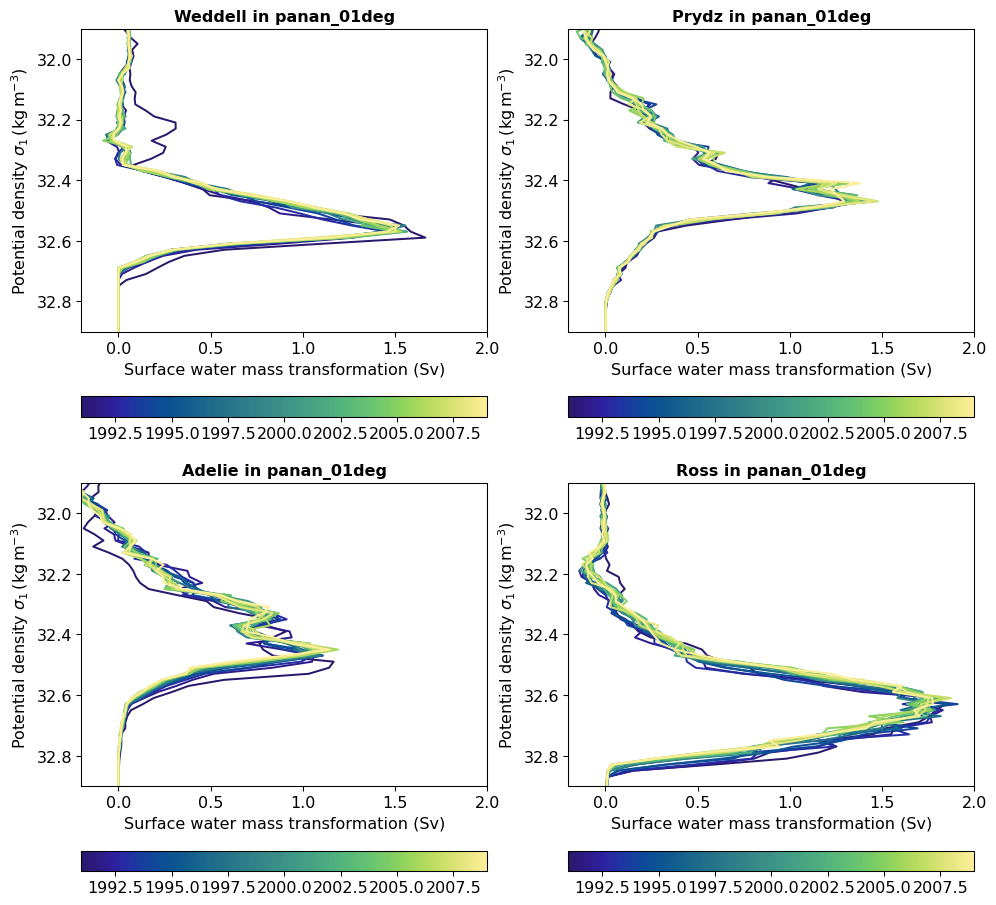

In [20]:
plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=.05)

expt = 'panan_01deg'
plot_swmt_in_each_DSW_region_each_year(expt, time_slice=slice('1991', '2009'))


#### -> shift of SWMT peak to lighter density classes in panan-01 significantly reduced, but still a slight shift in the Adelie and Ross

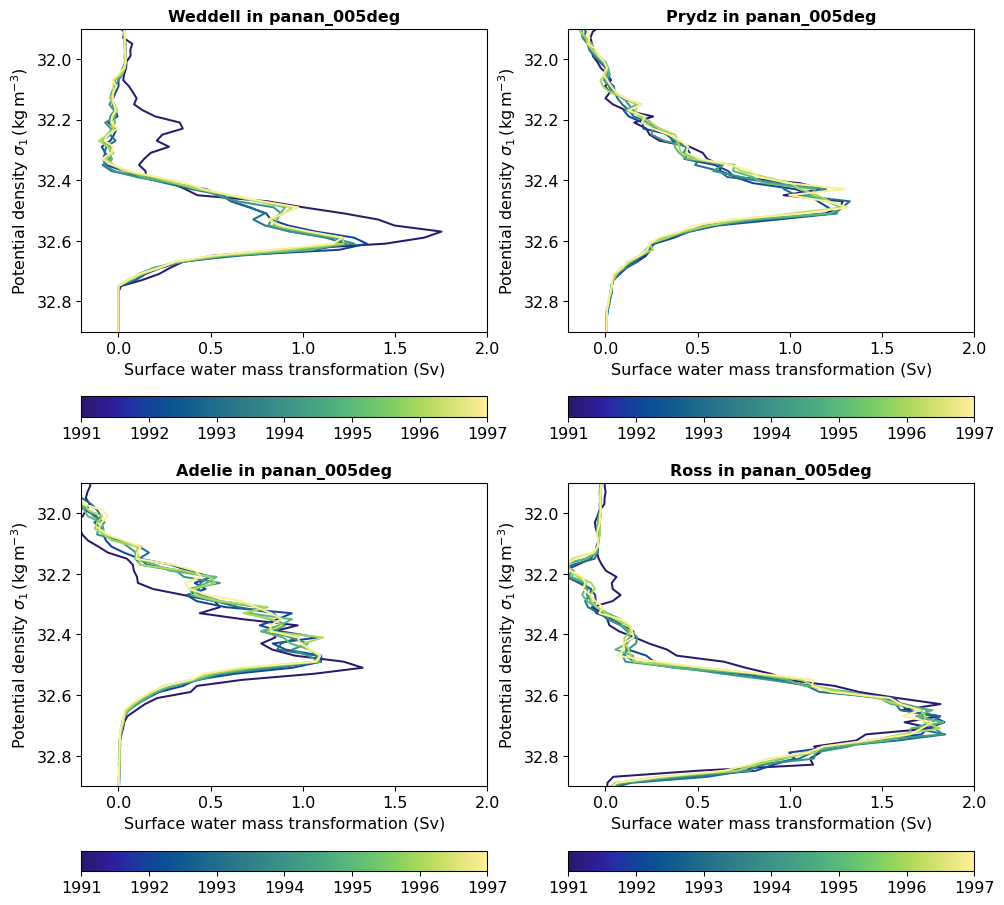

In [21]:
plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=.05)

expt = 'panan_005deg'
plot_swmt_in_each_DSW_region_each_year(expt)

#### -> no shift of the peak SWMT density in panan-005

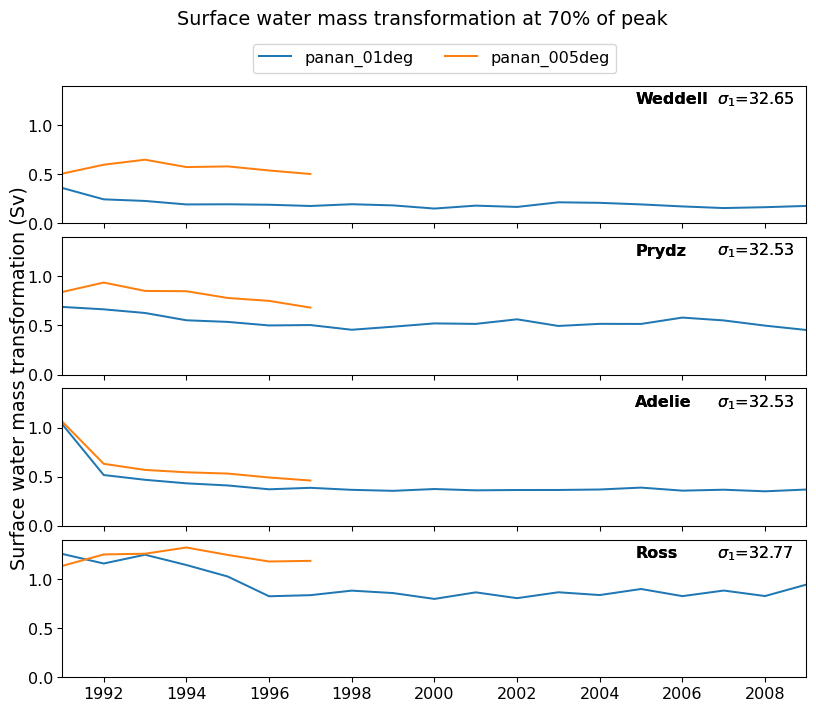

In [22]:
fig = plt.figure(figsize=(10, 8))
plt.subplots_adjust(hspace=.1)
plot_swmt_timeseries(ekeys)
fig.supylabel('Surface water mass transformation (Sv)', x=.07)
fig.suptitle('Surface water mass transformation at 70% of peak')
plt.show()

#### -> SWMT rate is stable

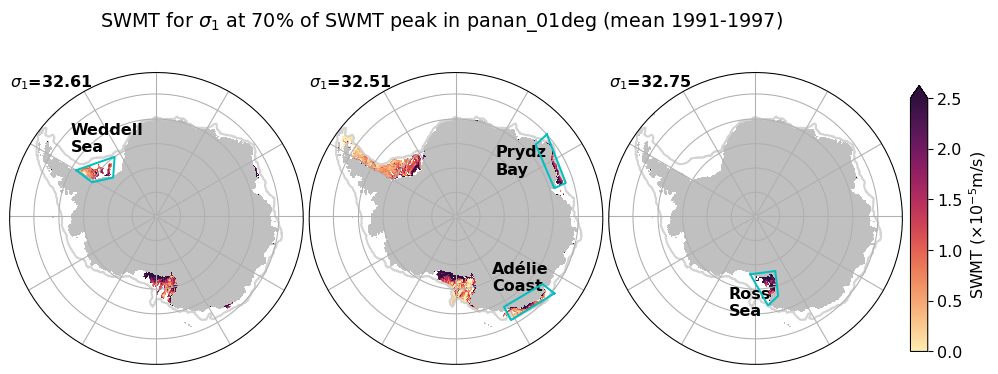

In [21]:
fig = plt.figure(figsize=(12, 4.5))
plt.subplots_adjust(wspace=0.02)
expt = 'panan_01deg'
time_slice = slice('1991', '1997')
plot_swmt_maps(expt, time_slice)
fig.suptitle('SWMT for $\sigma_1$ at 70% of SWMT peak in ' + expt +
             ' (mean ' + time_slice.start + '-' + time_slice.stop + ')')
plt.show()

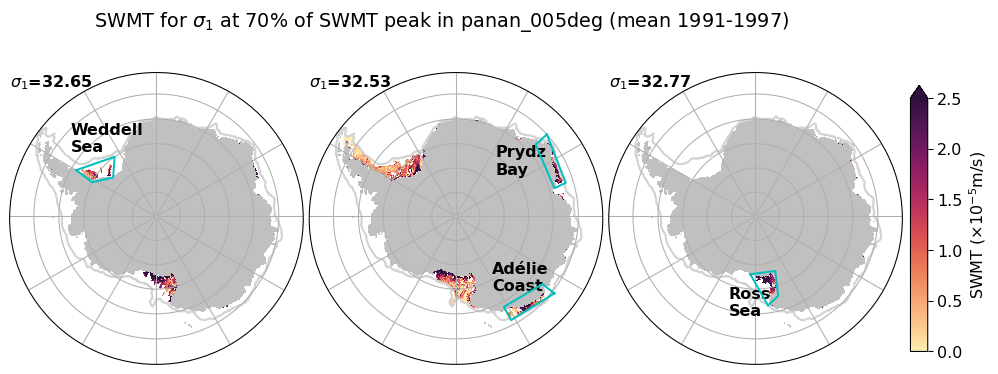

In [22]:
fig = plt.figure(figsize=(12, 4.5))
plt.subplots_adjust(wspace=0.02)
expt = 'panan_005deg'
time_slice = slice('1991', '1997')
plot_swmt_maps(expt, time_slice)
fig.suptitle('SWMT for $\sigma_1$ at 70% of SWMT peak in ' + expt +
             ' (mean ' + time_slice.start + '-' + time_slice.stop + ')')
plt.show()

#### -> chosen areas capture SWMT

### only mean over last 4 years of panan-005

In [23]:
start_time = '1994-01-01'
end_time = '1997-12-31'

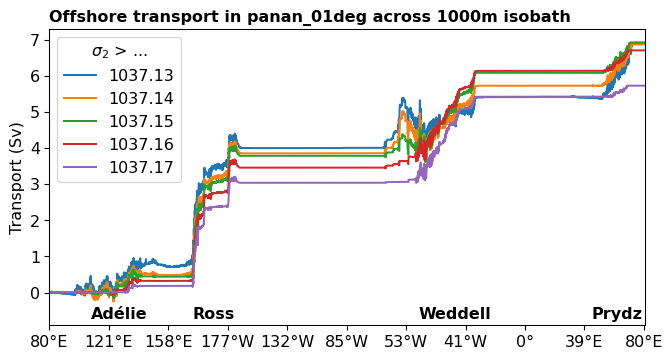

In [24]:
plot_offshore_transp_circumpolar_diff_densities(
    'panan_01deg', sig=np.arange(1037.13, 1037.18, .01), contour_depth=1000,
    time_slice=slice(start_time, end_time))

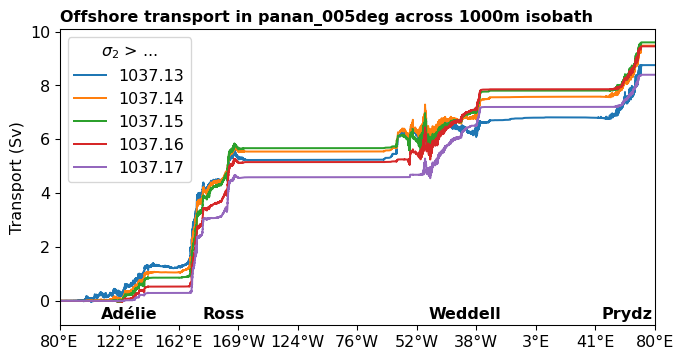

In [25]:
plot_offshore_transp_circumpolar_diff_densities(
    'panan_005deg', sig=np.arange(1037.13, 1037.18, .01), contour_depth=1000,
    time_slice=slice(start_time, end_time))

#### -> use $\sigma_2$ > 37.15 to capture all offshore transport across 1000 m isobath

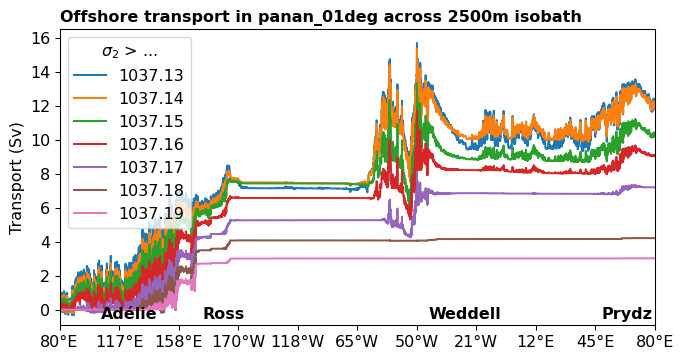

In [26]:
plot_offshore_transp_circumpolar_diff_densities(
    'panan_01deg', sig=np.arange(1037.13, 1037.2, .01), contour_depth=2500,
    time_slice=slice(start_time, end_time))

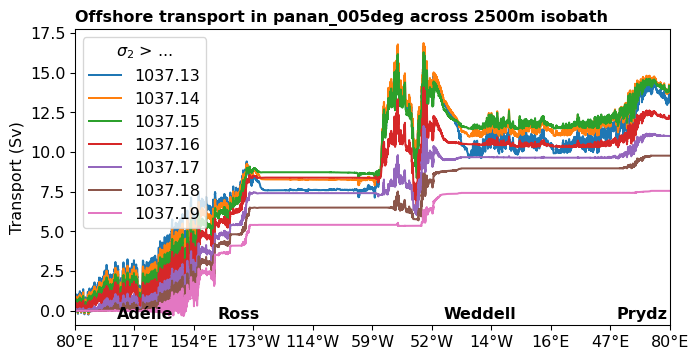

In [27]:
plot_offshore_transp_circumpolar_diff_densities(
    'panan_005deg', sig=np.arange(1037.13, 1037.2, .01), contour_depth=2500,
    time_slice=slice(start_time, end_time))

#### -> $\sigma_2$ > 37.15 captures all offshore transport all the way to the 2500 m isobath in panan-005, but in panan-01 only lighter thresholds do that (probably due to more mixing?). No export for $\sigma_2$ > 37.18 from the Weddell in panan-01, but about 1.5 Sv in panan-005.

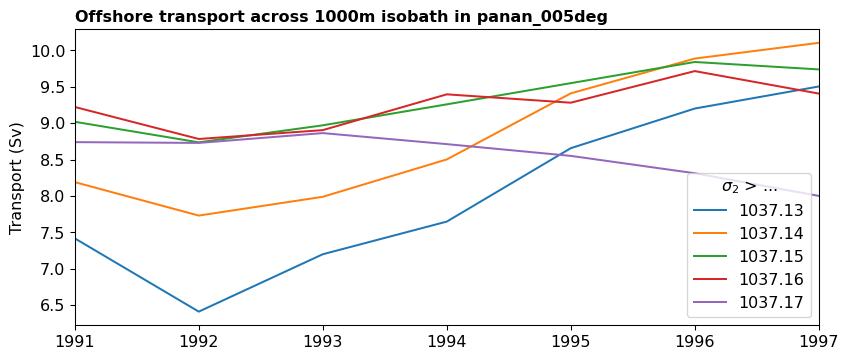

In [28]:
plot_offshore_transp_timeseries_diff_densities(
    'panan_005deg', sig=np.arange(1037.13, 1037.18, .01),
    time_slice=None)

#### -> time series for $\sigma_2$ > 37.15 looks quite stable for 1995-1997

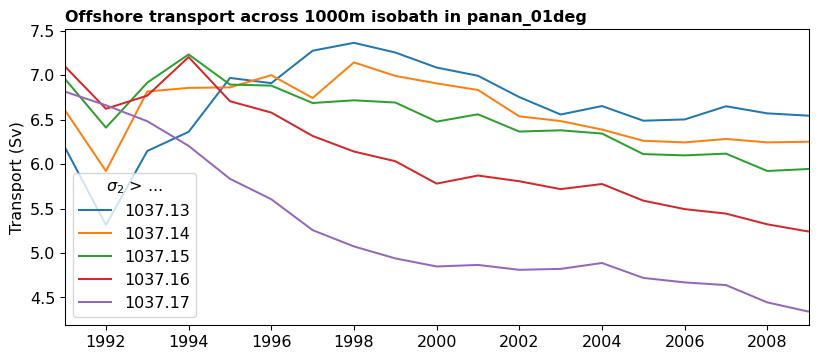

In [29]:
plot_offshore_transp_timeseries_diff_densities(
    'panan_01deg', sig=np.arange(1037.13, 1037.18, .01),
    time_slice=None)

#### -> transport for $\sigma_2$ > 37.15 reduces over time

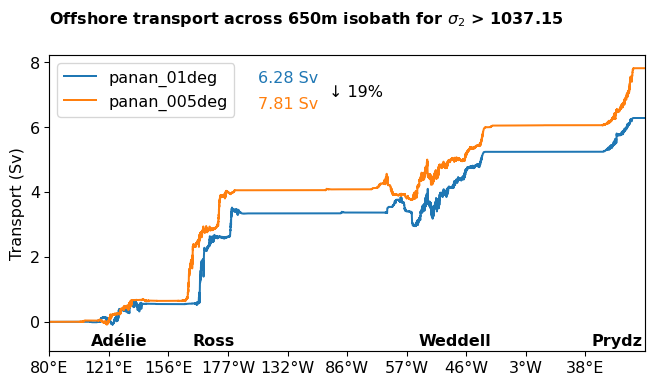

In [30]:
plot_offshore_transp_circumpolar_diff_resolution(
    contour_depth=650, sig=1037.15, time_slice=slice(start_time, end_time))

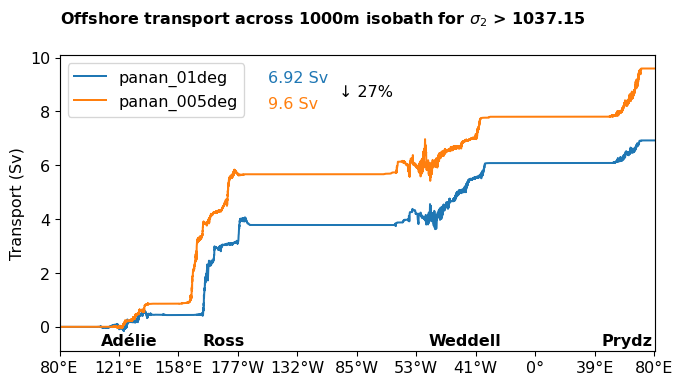

In [31]:
plot_offshore_transp_circumpolar_diff_resolution(
    contour_depth=1000, sig=1037.15, time_slice=slice(start_time, end_time))

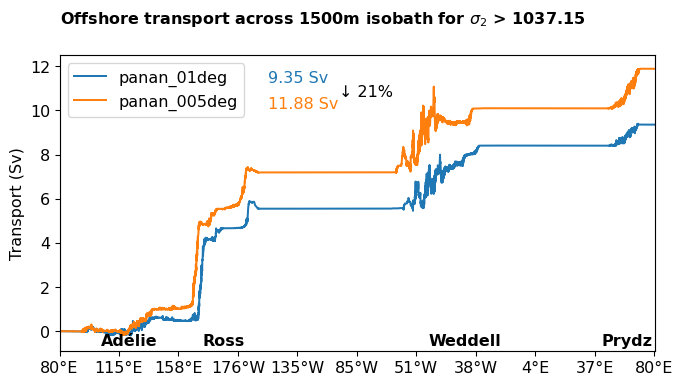

In [32]:
plot_offshore_transp_circumpolar_diff_resolution(
    contour_depth=1500, sig=1037.15, time_slice=slice(start_time, end_time))

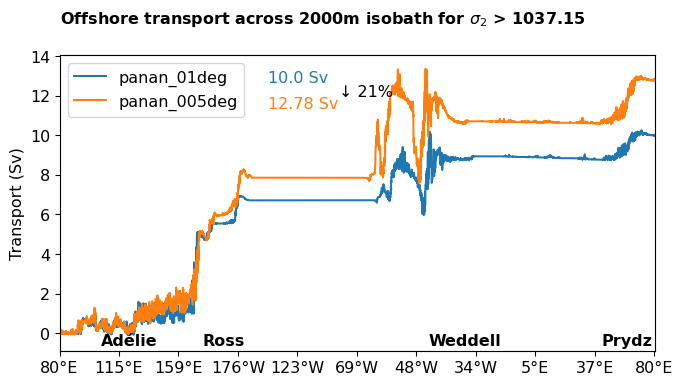

In [33]:
plot_offshore_transp_circumpolar_diff_resolution(
    contour_depth=2000, sig=1037.15, time_slice=slice(start_time, end_time))

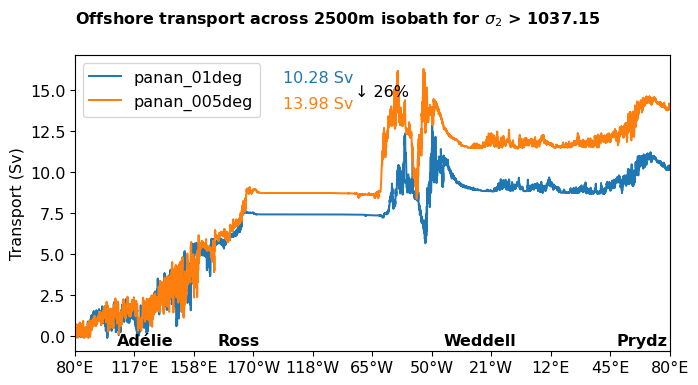

In [34]:
plot_offshore_transp_circumpolar_diff_resolution(
    contour_depth=2500, sig=1037.15, time_slice=slice(start_time, end_time))

#### -> between 20% and nearly 30% less offshore transport in panan-01 across different isobaths, especially due to a reduction from the Ross and Prydz

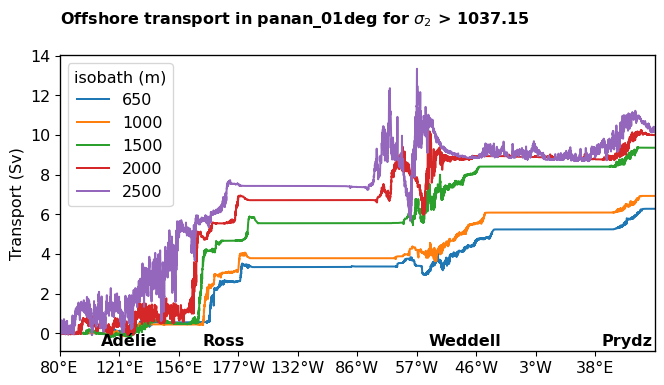

In [35]:
plot_offshore_transp_circumpolar_diff_isobath(
    'panan_01deg', contour_depth=[650, 1000, 1500, 2000, 2500],
    sig=1037.15, time_slice=slice(start_time, end_time))

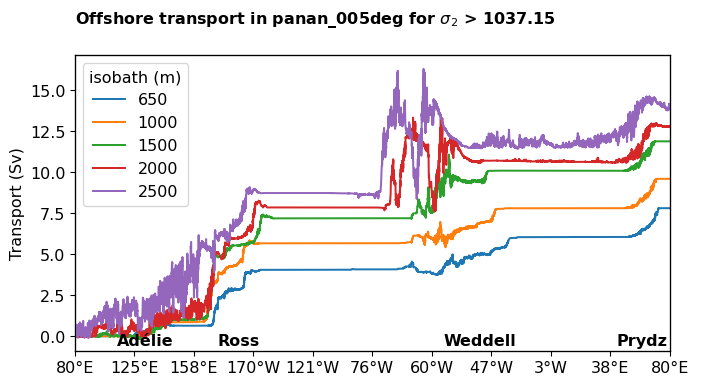

In [36]:
plot_offshore_transp_circumpolar_diff_isobath(
    'panan_005deg', contour_depth=[650, 1000, 1500, 2000, 2500],
    sig=1037.15, time_slice=slice(start_time, end_time))

#### -> increase in transport especially between 650 and 1500 m isobath (in panan-01 mostly between 1000 and 1500 m whereas it's a similar increase from 650 to 1000 to 1500 m in panan-005)

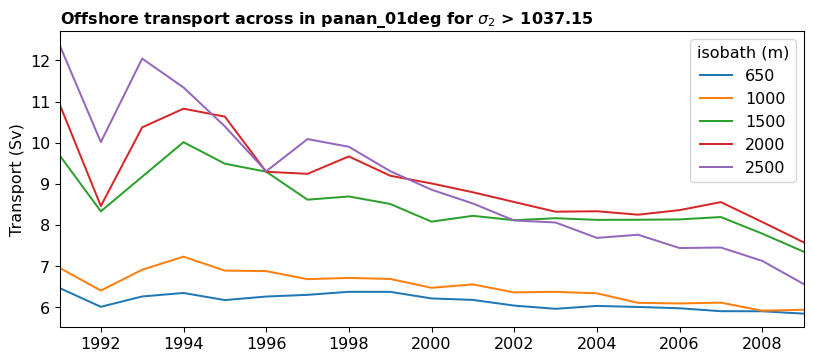

In [37]:
plot_offshore_transp_timeseries_diff_isobath(
    'panan_01deg', contour_depth=[650, 1000, 1500, 2000, 2500],
    sig=1037.15, time_slice=None)

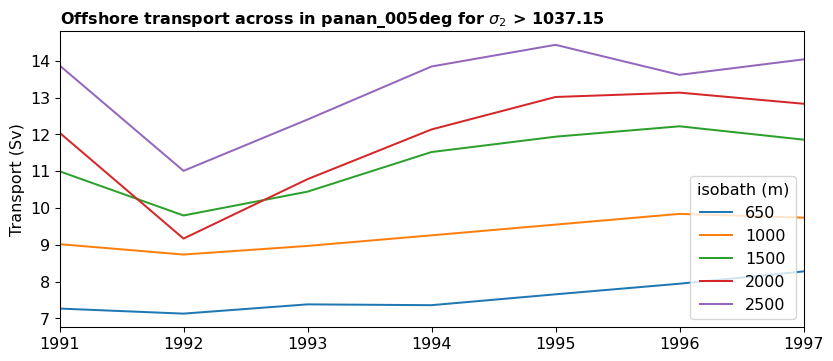

In [38]:
plot_offshore_transp_timeseries_diff_isobath(
    'panan_005deg', contour_depth=[650, 1000, 1500, 2000, 2500],
    sig=1037.15, time_slice=None)

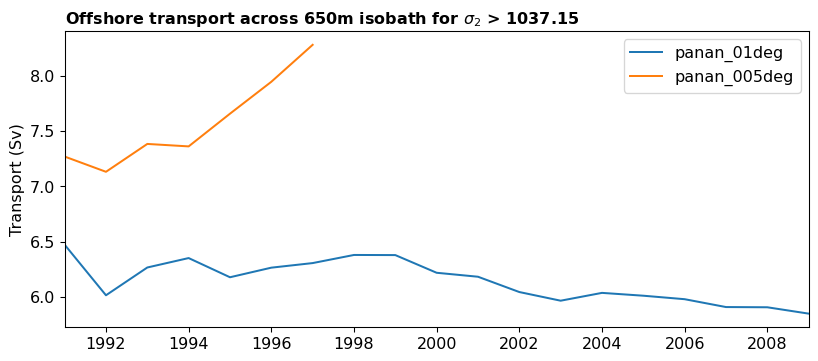

In [20]:
plot_offshore_transp_timeseries_diff_resolution(
    contour_depth=650, sig=1037.15, time_slice=None)

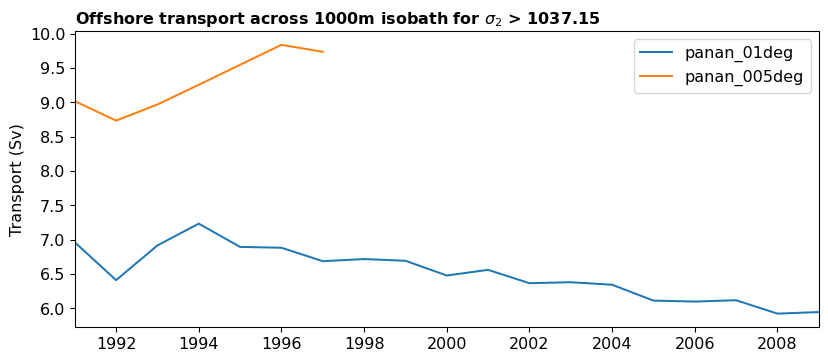

In [39]:
plot_offshore_transp_timeseries_diff_resolution(
    contour_depth=1000, sig=1037.15, time_slice=None)

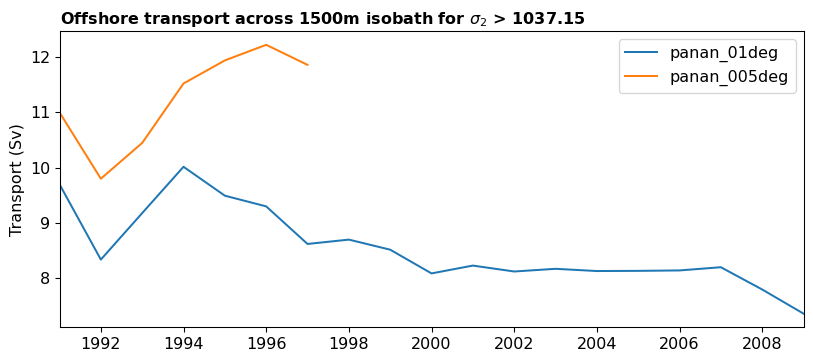

In [21]:
plot_offshore_transp_timeseries_diff_resolution(
    contour_depth=1500, sig=1037.15, time_slice=None)

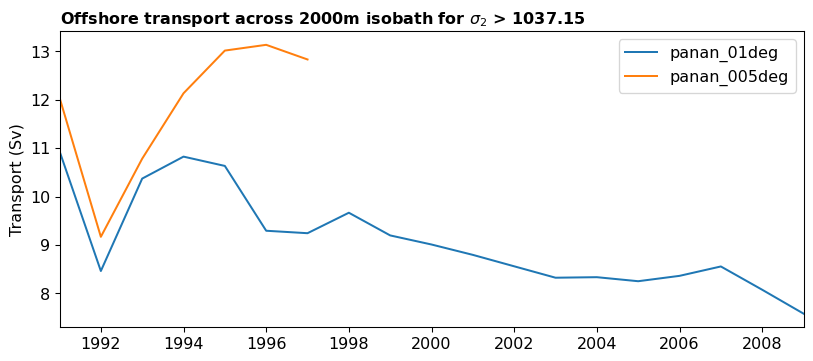

In [40]:
plot_offshore_transp_timeseries_diff_resolution(
    contour_depth=2000, sig=1037.15, time_slice=None)

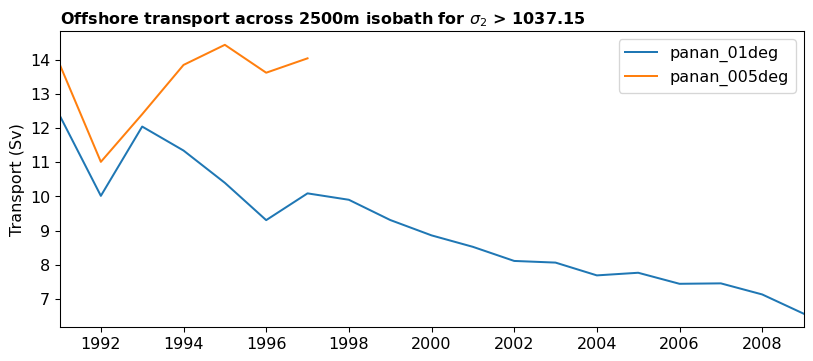

In [41]:
plot_offshore_transp_timeseries_diff_resolution(
    contour_depth=2500, sig=1037.15, time_slice=None)

#### -> it takes about 4 years for the transport to reach the 2500 m isobath

In [35]:
%%time
lat = -60
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['psi_60S'] = e['psi'].sel(yq=lat, method='nearest').sel(rho2_l=slice(1036.5, None)).min(
        dim='rho2_l').compute()
    print(e['expt_name'] + ' done')

panan_01deg_jra55_ryf done
panan_005deg_jra55_ryf done
CPU times: user 1min 14s, sys: 6.77 s, total: 1min 21s
Wall time: 5min 16s


In [36]:
%%time
lat = -40
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['psi_40S'] = e['psi'].sel(yq=lat, method='nearest').sel(rho2_l=slice(1036.5, None)).min(
        dim='rho2_l').compute()
    print(e['expt_name'] + ' done')

panan_01deg_jra55_ryf done
panan_005deg_jra55_ryf done
CPU times: user 1min 8s, sys: 6.94 s, total: 1min 15s
Wall time: 4min 43s


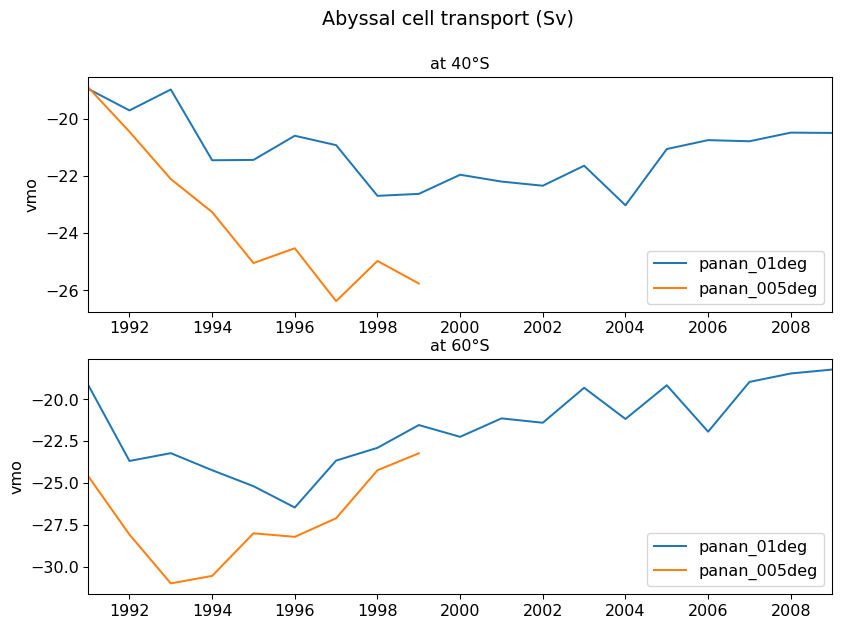

In [37]:
fig = plt.figure(figsize=(10, 7))

plt.subplot(2, 1, 1)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['psi_40S'].groupby('time.year').mean().plot(label=ekey)
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel('')
plt.legend()
plt.title('at 40°S')

plt.subplot(2, 1, 2)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['psi_60S'].groupby('time.year').mean().plot(label=ekey)
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel('')
plt.legend()
plt.title('at 60°S')

plt.suptitle('Abyssal cell transport (Sv)')
plt.show()